### A/B-тестирование с показателями кликабельности (CTR)

A/B-тестирование - эксперимент по двум вариантам, чтобы увидеть, какой работает лучше на основе данной метрики

### Chi-Squared Test

Так как проводится A/B-тест на конверсиях, которые являются дискретной переменной, подчиняющейся распределению Бернулли, следует использовать тест хи-квадрат.

Шаги для проведения теста на хи-квадрат:
1. Рассчитать критерий хи-квадрат
2. Рассчитать p-значение
3. Сравнить p-значение с уровнем значимости

$ x^2 = \Sigma \frac{(observed_i - expected_i)^2}{expected_i} $

### Data 

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ab-testing/ab_data.csv


In [2]:
df = pd.read_csv('/kaggle/input/ab-testing/ab_data.csv')

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

In [5]:
df_cleaned = df.loc[(df['group'] == 'control') & (df['landing_page'] == 'old_page') | (df['group'] == 'treatment') & (df['landing_page'] == 'new_page')]
df_cleaned.groupby(['group','landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


Проверка на дубли

In [6]:
df_cleaned['user_id'].duplicated().sum()

1

In [7]:
df_cleaned[df_cleaned.duplicated(['user_id'],keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

In [8]:
df[df['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Удаление дублей

In [9]:
df_cleaned = df.drop_duplicates(subset='user_id', keep="first")

### Exploratory Data Analysis

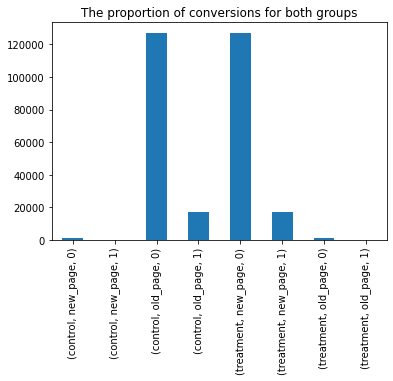

In [10]:
groups = df_cleaned.groupby(['group','landing_page','converted']).size()
groups.plot.bar(xlabel = '')
plt.title('The proportion of conversions for both groups')
plt.show()

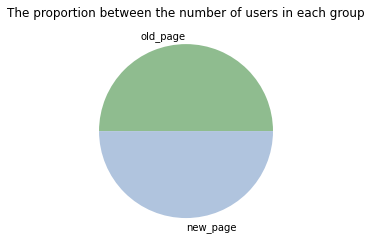

In [11]:
lbls = df_cleaned['landing_page'].unique().tolist()
plt.pie(df_cleaned['landing_page'].value_counts(), labels = lbls, colors = ['darkseagreen', 'lightsteelblue'])
plt.title('The proportion between the number of users in each group')
plt.show()

### Data Preparation

In [12]:
# Re-arrrange data into 2x2 for Chi-Squared

# 1) Split groups into two separate DataFrames
a = df_cleaned[df_cleaned['group'] == 'control']
b = df_cleaned[df_cleaned['group'] == 'treatment']

# 2) A-click, A-noclick, B-click, B-noclick
a_click = a.converted.sum()
a_noclick = a.converted.size - a.converted.sum()
b_click = b.converted.sum()
b_noclick = b.converted.size - b.converted.sum()

# 3) Create np array
T = np.array([[a_click, a_noclick], [b_click, b_noclick]])

### Chi-Squared Test

In [13]:
print(stats.chi2_contingency(T,correction=False)[1])

0.22689933216132585


P-значение было рассчитано на 22,7%. При уровне значимости 5% мы можем сделать вывод, что p-значение больше альфа и что мы не отвергаем нулевую гипотезу. Проще говоря, нет никакого значения в преобразованиях между старой и новой веб-страницей.

In [14]:
# Sanity Check
a_CTR = a_click / (a_click + a_noclick)
b_CTR = b_click / (b_click + b_noclick)
print(a_CTR, b_CTR)

0.12029717968491792 0.11884253398646046


Коэффициент конверсии между двумя группами и разница между ними действительно минимальны